# CogPonder: N-Back PyTorch Lightning

This notebook implements the CogPonder algorithm using PyTorch Lightning. It assumes fixed hyperparameters and fits the model to a single-subject dataset. It wraps a simple RRN with a pondering lambda layer and trains it on the *Self-Regulation Ontology* dataset.

## Data
The SRO-2back dataset interface provides the following features from the *Self-Regulation Ontology* study:

- `X`: previous 3 symbols for the subject $i$ and trial $j$; For each subject, $X_i$ is a 2-dimensional vector of integers of shape (3, $N_{\text{trials}}$).
- `trial_types`: Correct match, incorrect match, correct-non-match, incorrect-non-match for each trial $i$.
- `is_targets`: whether the trial $i$ is a match; it is a boolean.
- `response`: the response of the subject for the trial i; it is a boolean.
- `response_steps`: the response step of the subject for the trial i; Response step is an integer and represents *response times* in 50ms steps. This step duration is a hyperparameter of the data module.

## Hyperparameters

- `n_embeddings`: number of hidden units in the recurrent ICOM model. Defaults to $N_{\text{symbols} + 1}$
- `rec_loss_beta`: the beta parameter of the loss function. Defaults to 0.5.
- `cog_loss_beta`: the beta parameter of the loss function. Defaults to 0.5.
- `learning_rate`: the learning rate of the optimizer. Defaults to 0.0001.
- `max_response_step`: maximum response step in the dataset. Defaults to $\max(\text{response\_step}) + 10$.

## Criterion

$L = L_{\text{reconstruction}} + L_{\text{cognitive}}$


In [1]:
%reload_ext autoreload
%autoreload 3

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from functools import partial
from pytorch_lightning.callbacks import RichProgressBar, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from cogponder import CogPonderNet
from cogponder.datasets import NBackMockDataset, NBackDataModule, NBackSRODataset
from pathlib import Path

from cogponder.losses import ReconstructionLoss, CognitiveLoss



In [2]:
# data
data = NBackSRODataset(n_subjects=1, n_back=2) # shape (n_subjects, (...))
datamodule = NBackDataModule(data, batch_size=256, num_workers=1)
n_symbols = torch.unique(data[0][0]).shape[0]
max_response_step = 25 # data[0][4].max().item() + 1 # max number of steps = 2 * max observed RT

# parameter space
CONFIG = {
    'rec_loss_beta': 1.,
    'cog_loss_beta': .3,
    'loss_by_trial_type': False,
    'learning_rate': 1e-3,
    'max_response_step': max_response_step,
    'inputs_dim': data[0][0].size(1),
    'embeddings_dim': n_symbols,
}
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
# pondering model

model = CogPonderNet(CONFIG, example_input_array=data[0][0][:1].to(device))

# # DEBUG
# X = data[0][0][:10]
# y_true = data[0][3][:10]
# rt_true = data[0][4][:10]
# y_steps, p_halts, rt_pred = model(X)
# loss_func = CognitiveLoss(CONFIG['max_response_step'])
# l = loss_func(rt_pred, rt_true)
# 'l', l, rt_pred, rt_true

trainer = pl.Trainer(
    max_epochs=5000,
    # min_epochs=1000,
    accelerator='auto',
    auto_lr_find=True,
    log_every_n_steps=1,
    overfit_batches=True,
    # accumulate_grad_batches=4,
    callbacks=[
        RichProgressBar(),
        EarlyStopping(monitor='val_loss', patience=500, mode='min', min_delta=0.01),
    ])

trainer.tune(model, datamodule=datamodule)
trainer.fit(model, datamodule=datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃         In sizes ┃ Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0 │ train_accuracy │ Accuracy           │      0 │                ? │         ? │
│ 1 │ val_accuracy   │ Accuracy           │      0 │                ? │         ? │
│ 2 │ cog_loss_fn    │ CognitiveLoss      │      0 │                ? │         ? │
│ 3 │ rec_loss_fn    │ ReconstructionLoss │      0 │                ? │         ? │
│ 4 │ halt_node      │ Sequential         │      6 │           [1, 5] │    [1, 1] │
│ 5 │ output_node    │ Sequential         │      6 │           [1, 5] │    [1, 1] │
│ 6 │ recurrent_node │ GRUCell            │    150 │ [[1, 3], [1, 5]] │    [1, 5] │
└───┴────────────────┴────────────────────┴────────┴──────────────────┴───────────┘

Trainable params: 162                                                                                              
Non-trainable params: 0                                                                                            
Total params: 162                                                                                                  
Total estimated model params size (MB): 0

Output()

/home/morteza/mambaforge/envs/ponder/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connect
or.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this
machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/morteza/mambaforge/envs/ponder/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connect
or.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this
machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

In [4]:
# DEBUG: Plot LR tuning results
# lr_finder = trainer.tuner.lr_find(model, max_lr=2, datamodule=datamodule)
# fig = lr_finder.plot(suggest=True)
# fig.show()
# model.hparams.learning_rate = lr_finder.suggestion()
# trainer.fit(model, datamodule=datamodule)

In [5]:
# DEBUG

import torch
import torchmetrics

X_train, _, y_train, _, rt_train = datamodule.dataset[datamodule.train_dataset.indices]
X_test, _, y_test, _, rt_test = datamodule.dataset[datamodule.test_dataset.indices]

with torch.no_grad():
    model.eval()
    y_train_steps,_,rt_train_pred = model(X_train)
    y_test_steps,_,rt_test_pred = model(X_test)

    y_train_pred = y_train_steps.gather(dim=0, index=rt_train_pred[None, :] - 1,)[0]  # (batch_size,)
    y_test_pred = y_test_steps.gather(dim=0, index=rt_test_pred[None, :] - 1,)[0]  # (batch_size,)

    accuracy_fn = torchmetrics.Accuracy()
    train_accuracy = accuracy_fn(y_train_pred, y_train)
    print('TRAIN ACCURACY', train_accuracy.item())


    accuracy_fn = torchmetrics.Accuracy()
    test_accuracy = accuracy_fn(y_test_pred, y_test)
    print('TEST ACCURACY', test_accuracy.item())

    # DEBUG report the ground truth and predicted response times
    print('TRUE TRAIN:', rt_train.detach().tolist(), '\nPRED TRAIN:',  rt_train_pred.tolist())
    print('TRUE TEST:', rt_test.detach().tolist(), '\nPRED TEST:',  rt_test_pred.tolist())

# DEBUG report medians
# rt_train_pred.median(), rt_train.float().median()
# rt_test_pred.median(), rt_test.float().median()


TRAIN ACCURACY 0.9319728016853333
TEST ACCURACY 0.9387755393981934
TRUE TRAIN: [9, 8, 10, 14, 13, 10, 8, 9, 11, 10, 11, 8, 10, 8, 9, 9, 5, 5, 7, 7, 6, 6, 6, 6, 7, 12, 15, 14, 10, 11, 9, 8, 12, 12, 12, 10, 7, 9, 13, 14, 12, 8, 5, 5, 6, 10, 11, 10, 10, 8, 8, 14, 9, 10, 7, 7, 6, 5, 6, 6, 10, 8, 10, 8, 10, 6, 7, 7, 10, 10, 8, 8, 7, 6, 7, 11, 10, 15, 9, 5, 5, 5, 5, 7, 8, 14, 10, 6, 7, 5, 9, 9, 12, 10, 11, 14, 6, 8, 10, 9, 15, 6, 6, 8, 14, 12, 13, 9, 8, 8, 7, 14, 13, 8, 7, 10, 12, 8, 8, 9, 10, 5, 7, 8, 7, 6, 11, 6, 10, 9, 8, 5, 9, 7, 8, 10, 8, 11, 8, 8, 7, 8, 6, 10, 7, 5, 8] 
PRED TRAIN: [1, 18, 25, 1, 12, 25, 25, 25, 25, 1, 25, 25, 25, 22, 1, 25, 1, 25, 25, 25, 25, 25, 25, 1, 25, 14, 25, 25, 25, 1, 25, 9, 13, 25, 1, 25, 5, 25, 1, 25, 25, 1, 5, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 1, 25, 25, 25, 25, 1, 23, 7, 1, 25, 25, 1, 1, 23, 25, 25, 25, 25, 25, 17, 1, 1, 16, 25, 3, 3, 3, 5, 1, 25, 25, 1, 11, 25, 15, 25, 5, 25, 2, 1, 25, 10, 25, 25, 25, 25, 25, 2, 4, 25, 4, 16, 25, 25, 25, 25, 25,

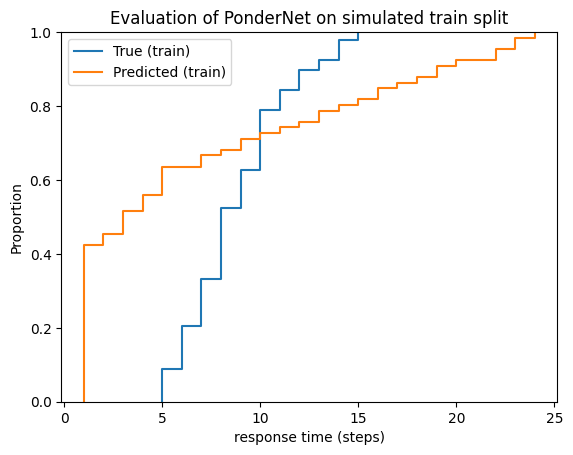

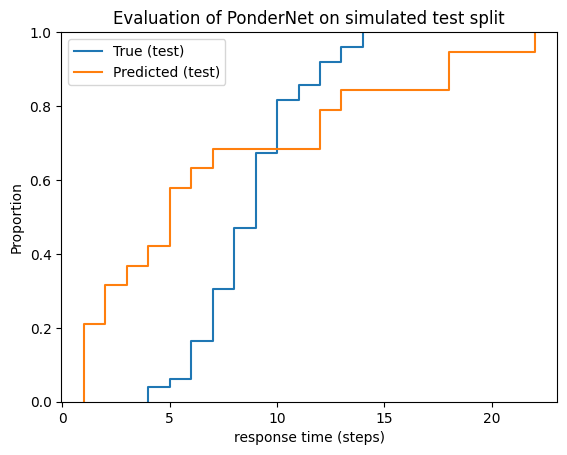

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

RT_CAP = max_response_step # data[0][4].max().item()

sns.ecdfplot(rt_train, label='True (train)')
sns.ecdfplot(rt_train_pred[rt_train_pred < RT_CAP], label='Predicted (train)')

plt.title('Evaluation of PonderNet on simulated train split')
plt.xlabel('response time (steps)')

plt.legend()
plt.show()

sns.ecdfplot(rt_test, label='True (test)')
sns.ecdfplot(rt_test_pred[rt_test_pred < RT_CAP], label='Predicted (test)')

plt.title('Evaluation of PonderNet on simulated test split')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()

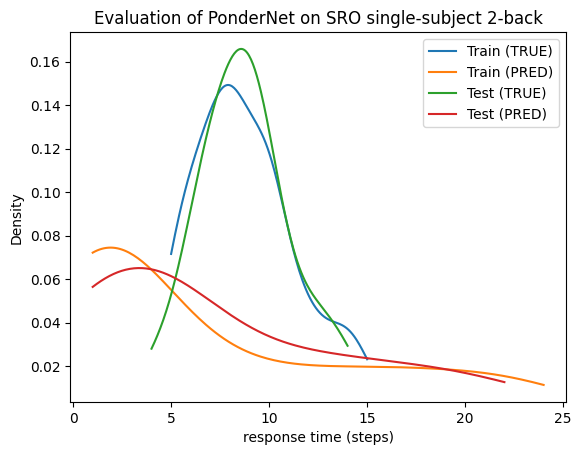

In [7]:

sns.kdeplot(rt_train, label='Train (TRUE)', cut=0)
sns.kdeplot(rt_train_pred[rt_train_pred < RT_CAP], label='Train (PRED)', cut=0)

sns.kdeplot(rt_test, label='Test (TRUE)', cut=0)
sns.kdeplot(rt_test_pred[rt_test_pred < RT_CAP], label='Test (PRED)', cut=0)


plt.title('Evaluation of PonderNet on SRO single-subject 2-back')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()